# Figure 6: Full reconstruction timeseries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import xarray as xr

from scipy import signal
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
def load_annual_satellite_anom(ANOM_END): 
    """Loads annual satellite data and finds anomalies that start at 1979 and go 
       to ANOM_END. 
    """
    # Import satellite data Fetterer v3: 
    fet_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/Fetterer_v3/'
    #fet_file = 'Fetterer_data_v3_annual_1978_2017.npz'
    fet_file = 'Fetterer_data_v3_annual_78_17.npz'

    # Load annual data
    fet_loc = fet_directory + fet_file
    fet_data = np.load(fet_loc)

    fet_sie = fet_data['si_extent'][1:]
    fet_sia = fet_data['si_area'][1:]
    fet_time = fet_data['time'][1:]

    # Find anomalies: 

    # Calculate mean 
    fet_anom_cent_sia = np.nanmean(fet_sia[np.where(fet_time<=ANOM_END)],axis=0)
    fet_anom_cent_sie = np.nanmean(fet_sie[np.where(fet_time<=ANOM_END)],axis=0)

    # Find anomalies:  
    fet_sia_anom = fet_sia - fet_anom_cent_sia
    fet_sie_anom = fet_sie - fet_anom_cent_sie
    
    return fet_sia_anom, fet_sie_anom, fet_time

In [3]:
plt.rcParams['figure.dpi']=300

In [4]:
anom_start = 1979
anom_end = 2000

## Load satellite data: 

In [5]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, fet_sie_anom, fet_time] = load_annual_satellite_anom(anom_end)

## Load reconstruction: 

In [7]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)

In [8]:
sie_ensmn_anom_allit_ccsm4 = recon_data_ccsm4.si_extent_ensemble_mean_anomalies.values
sie_97_5_allit_ccsm4  = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_2_5_allit_ccsm4  = recon_data_ccsm4.si_extent_2_5_percentiles.values

recon_years = recon_data_ccsm4.time.values
nobs_allit_ccsm4 = np.nanmean(recon_data_ccsm4.nobs_assimilated.values,axis=1)

In [9]:
Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
sie_ccsm4_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_ccsm4)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Plot: Figure 6

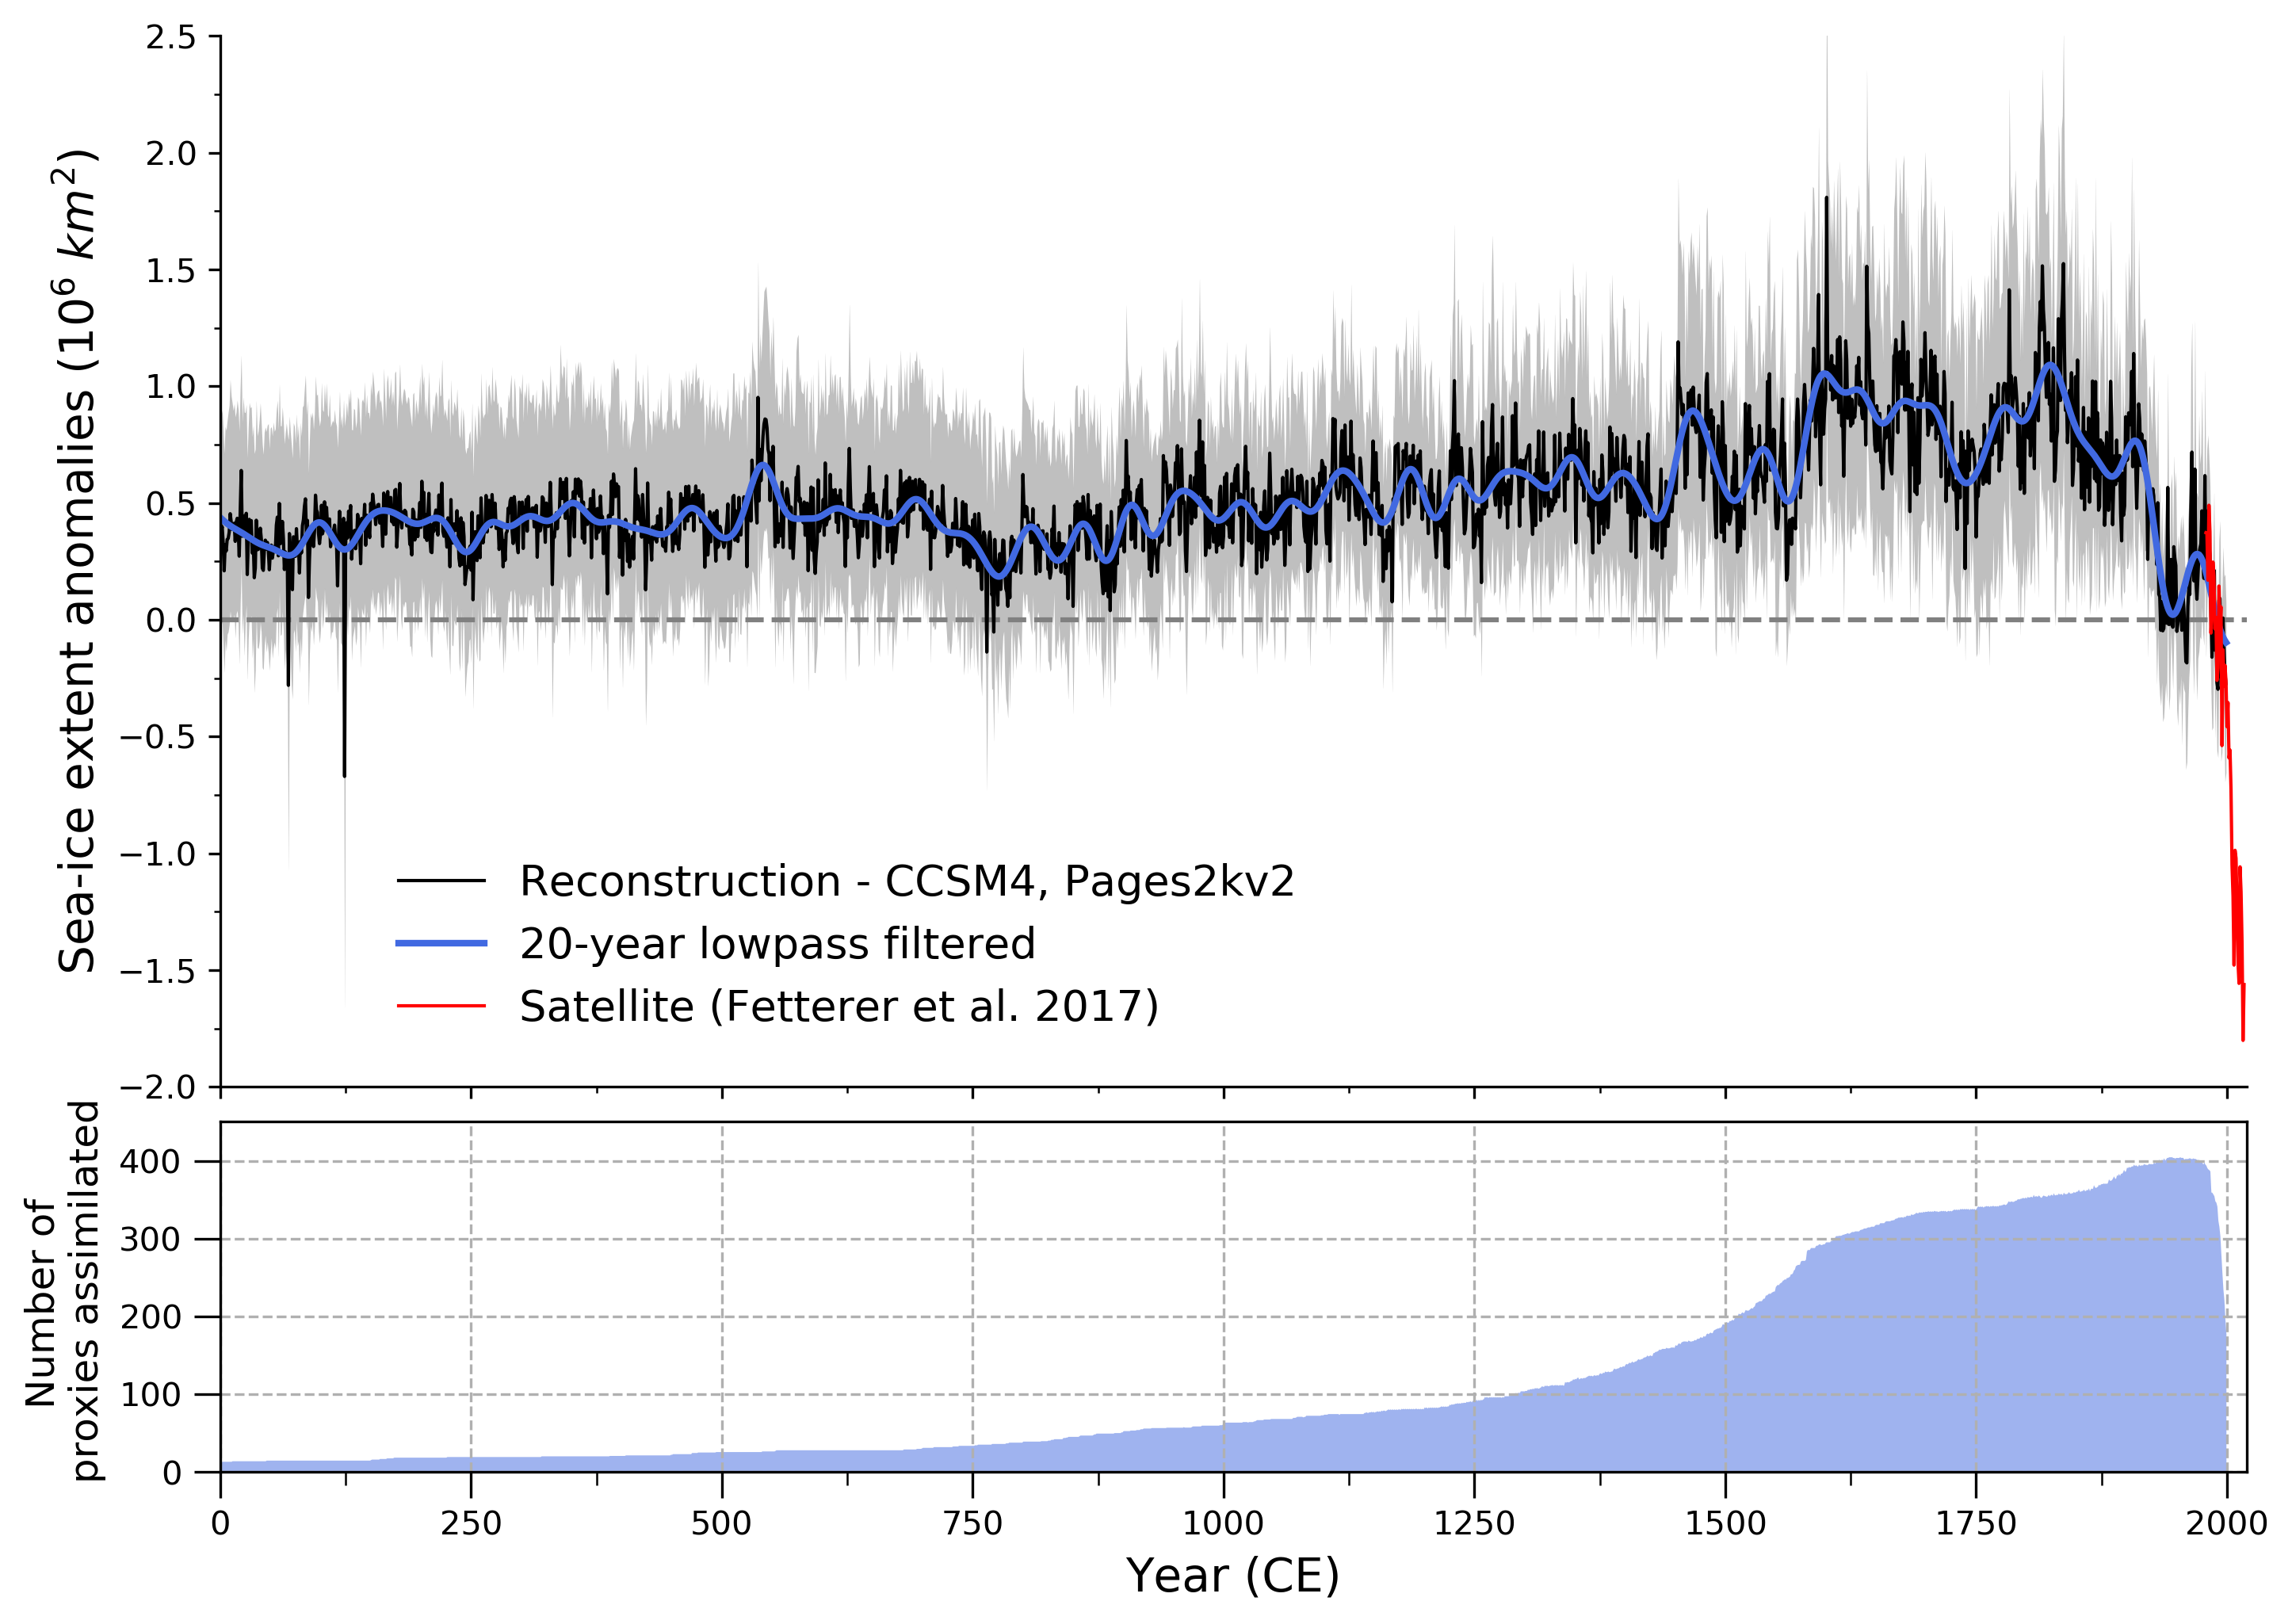

In [10]:
fig, (ax_recon,ax_prox) = plt.subplots(2, figsize=(11,8),sharex=True,
                                       gridspec_kw={"height_ratios": (.75,.25)})

ax_recon.axhline(0,linestyle='--',color='grey')

ax_recon.fill_between(recon_years,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,
                      color='gray',lw=0.01,alpha=0.5)
ax_recon.plot(recon_years,sie_ensmn_anom_allit_ccsm4,color='k',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=1)
ax_recon.plot(recon_years,sie_ccsm4_filt20,color='royalblue',
         label='20-year lowpass filtered',linewidth=2)
ax_recon.plot(fet_time,fet_sie_anom,label='Satellite (Fetterer et al. 2017)', 
              color='r',linewidth=1)

ax_recon.set_ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
ax_recon.legend(fontsize=13,bbox_to_anchor=(0.55,0.25),frameon=False)

ax_recon.set_xlim(0,2020)
ax_recon.set_ylim(-2,2.5)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(125))
ax_prox.tick_params(which='major', length=8)
ax_prox.tick_params(which='minor', length=4)

ax_prox.fill_between(recon_years,0,nobs_allit_ccsm4, linewidth=0.01,
                     color='royalblue',alpha=0.5)
ax_prox.set_xlabel('Year (CE)', fontsize=14)
ax_prox.set_ylabel('Number of \n proxies assimilated', fontsize=12)
ax_prox.grid(linestyle='--')

ax_prox.set_xlim(0,2020)
ax_prox.set_ylim(0,450)

plt.subplots_adjust(wspace=0, hspace=0.05)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sie_ccsm4_v_sat_nobs_10it_0_2017.png'
#plt.savefig(savedir+savename)